## Image segmentation with CamVid

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

In [8]:
path = untar_data(URLs.CAMVID)

In [9]:
path.ls()

[PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/valid.txt')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

## Data

In [11]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0001TP_007170.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_05760.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_06300.png')]

In [12]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f04410_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_007800_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0006R0_f01140_P.png')]

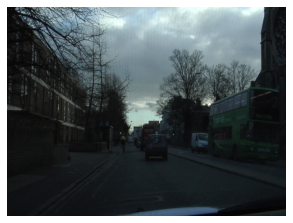

In [13]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

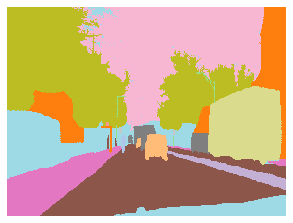

In [15]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [16]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[26, 26, 26,  ...,  4,  4,  4],
          [26, 26, 26,  ...,  4,  4,  4],
          [26, 26, 26,  ...,  4,  4,  4],
          ...,
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30]]]))

## Datasets

In [17]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [0]:
size = src_size//2
bs = 8

In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), tfm_y=True, size = size)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

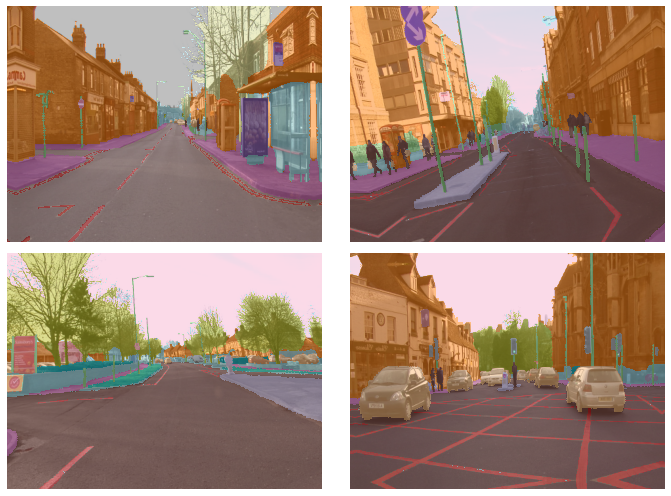

In [37]:
data.show_batch(2, figsize=(10,7))

## Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid
wd=1e-2

In [40]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


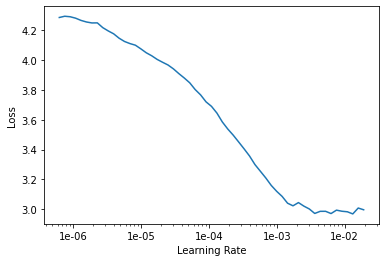

In [41]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=2e-4

In [43]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,2.389837,1.741557,0.595233,00:49
1,1.464536,1.068528,0.776137,00:47
2,1.025674,0.786329,0.832214,00:48
3,0.819752,0.708222,0.828407,00:47
4,0.680488,0.550462,0.859729,00:47
5,0.608333,0.508548,0.860876,00:47
6,0.555724,0.484083,0.870765,00:47
7,0.522455,0.479097,0.864380,00:48
8,0.481255,0.385315,0.890300,00:48
9,0.414864,0.334086,0.904291,00:47


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/100,lr)

In [48]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.390774,0.333883,0.904869,00:49
1,0.382769,0.331491,0.904084,00:48
2,0.376078,0.322957,0.907238,00:48
3,0.373492,0.329234,0.904720,00:48
4,0.378429,0.342249,0.902860,00:48
5,0.373529,0.321152,0.906516,00:48
6,0.367395,0.324791,0.908044,00:48
7,0.371637,0.325429,0.902900,00:49
8,0.354451,0.388111,0.891406,00:48
9,0.338218,0.289255,0.915091,00:48


In [0]:
learn.save('stage-2');

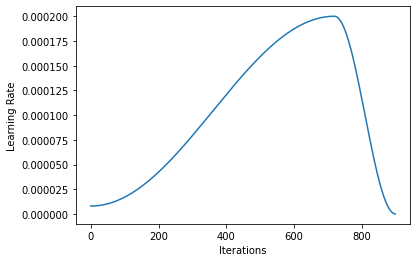

In [50]:
learn.recorder.plot_lr()

## Go big

In [19]:
learn=None
gc.collect()

4560

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [0]:
size = src_size
bs=8

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)

In [0]:
learn.load('stage-2');

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-3

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.197342,0.242197,0.929653
2,0.195649,0.237269,0.930523
3,0.192771,0.253759,0.926123
4,0.197877,0.244278,0.931226
5,0.197267,0.255444,0.927470
6,0.206536,0.371523,0.913392
7,0.210372,0.267855,0.927450
8,0.210874,0.278875,0.915120
9,0.205951,0.256743,0.929986
10,0.184149,0.227250,0.939358


In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/1000,lr/10)

In [0]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,0.163259,0.226014,0.939663
2,0.159221,0.223871,0.940497
3,0.159171,0.242006,0.938531
4,0.158257,0.223698,0.941702
5,0.156215,0.227719,0.941239
6,0.155152,0.226728,0.941032
7,0.150818,0.230083,0.940657
8,0.149479,0.229187,0.940948
9,0.148236,0.229072,0.941316
10,0.148074,0.234124,0.940629


In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big');

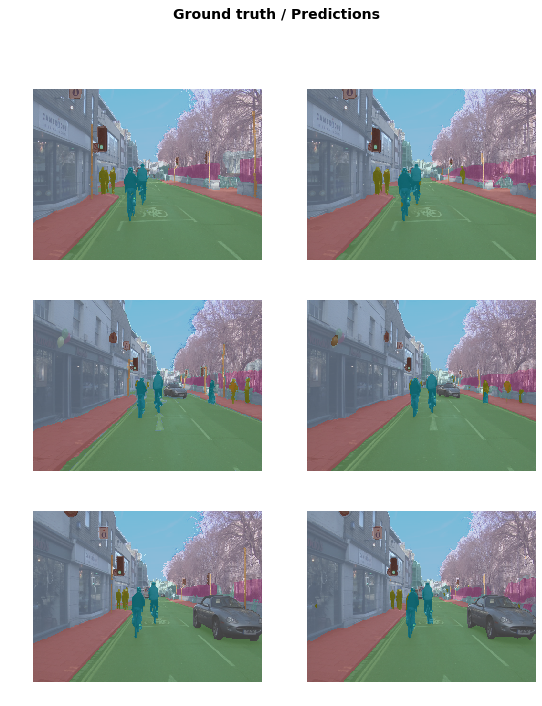

In [0]:
learn.show_results(rows=3, figsize=(9,11))

## fin

In [0]:
# start: 480x360

In [0]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 64, 180, 240]    9408       False     
______________________________________________________________________
BatchNorm2d          [8, 64, 180, 240]    128        True      
______________________________________________________________________
ReLU                 [8, 64, 180, 240]    0          False     
______________________________________________________________________
MaxPool2d            [8, 64, 90, 120]     0          False     
______________________________________________________________________
Conv2d               [8, 64, 90, 120]     36864      False     
______________________________________________________________________
BatchNorm2d          [8, 64, 90, 120]     128        True      
______________________________________________________________________
ReLU                 [8, 64, 90, 120]     0          False     
______________________________________________________________